# Requirements

In [ ]:
!pip install torch torchvision torchaudio timm tqdm pillow numpy matplotlib ftfy regex

In [ ]:
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

In [ ]:
!pip install kaolin==0.18.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.6.0_cu124.html

In [ ]:
!pip install "git+https://github.com/openai/CLIP.git"

# dataset.py

In [5]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import time
import pickle

# --- Dataset Configuration ---
IMAGE_PATH = "/kaggle/input/shapenet/ShapeNet/ShapeNetRendering"
POINTCLOUD_PATH = "/kaggle/input/shapenet/ShapeNet/ShapeNet_pointclouds"
CACHE_FILE = "/kaggle/working/shapenet_paths.pkl"
CATEGORIES = ['02691156', '02958343'] #Airplane and Car
NUM_POINTS = 1024

# --- DataLoader Configuration ---
BATCH_SIZE = 32
NUM_WORKERS = 4
RANDOM_SEED = 42

# --- Preprocessing Config ---
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# --- Dataset Class ---
class ShapeNetImage2PCDataset(Dataset):
    def __init__(self, data_items, transform=None):
        self.items = data_items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = self.items[idx]
        image_path = item['image_path']
        pc_path = item['pc_path']

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Load point cloud
        points = np.load(pc_path).astype(np.float32)

        # Point cloud normalization
        centroid = np.mean(points, axis=0)
        points -= centroid
        max_distance = np.max(np.sqrt(np.sum(points**2, axis=1)))
        if max_distance > 0:
            points /= max_distance
        
        points = torch.from_numpy(points)
        
        return image, points


# --- Data Item Collection ---
def get_data_items(image_root, pc_root, categories):
    all_items = []
    for category in categories:
        pc_category_path = os.path.join(pc_root, category)
        
        # Check if the point cloud category path exists before proceeding
        if not os.path.isdir(pc_category_path):
            continue

        for model_id in os.listdir(pc_category_path):
            image_model_path = os.path.join(image_root, category, model_id, 'rendering')
            
            if not os.path.isdir(image_model_path):
                continue

            pc_path = os.path.join(pc_category_path, model_id, f'pointcloud_{NUM_POINTS}.npy')
            if not os.path.exists(pc_path):
                continue
            
            image_paths = sorted(glob.glob(os.path.join(image_model_path, '*.png')))
            
            for image_path in image_paths:
                all_items.append({
                    'image_path': image_path,
                    'pc_path': pc_path,
                    'category': category,
                    'model_id': model_id
                })
                
    print(f"Path pre-computation finished. Found {len(all_items)} samples.")
    return all_items


# --- Main Data Loader Function ---
def get_dataloaders():
    if os.path.exists(CACHE_FILE):
        print("Loading dataset file paths from cache...")
        with open(CACHE_FILE, 'rb') as f:
            all_items = pickle.load(f)
        print(f"Loaded {len(all_items)} samples from cache.")
    else:
        print("Cache file not found. Pre-computing dataset file paths. This may take a while...")
        all_items = get_data_items(IMAGE_PATH, POINTCLOUD_PATH, CATEGORIES)
        
        if len(all_items) == 0:
            raise ValueError("Dataset is empty. Please check your data paths and categories.")
            
        print(f"Saving file paths to cache at {CACHE_FILE}...")
        with open(CACHE_FILE, 'wb') as f:
            pickle.dump(all_items, f)
        print("File paths saved. Subsequent runs will be much faster.")

    dataset = ShapeNetImage2PCDataset(
        data_items=all_items,
        transform=transform
    )

    total_size = len(dataset)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.2)
    test_size = total_size - train_size - val_size

    # Set a fixed seed for reproducibility before splitting the dataset
    torch.manual_seed(RANDOM_SEED)

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, 
        [train_size, val_size, test_size]
    )

    print(f"Total number of samples: {total_size}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# model.py

In [6]:
import torch
import torch.nn as nn
import timm
from typing import Tuple

# --- Model Configuration ---
D_MODEL = 256
NHEAD = 8
NUM_LAYERS = 6
DIM_FF = 1024
P_DROP = 0.1
GLOBAL_COND = True

# ---------------------------
# Building Blocks
# ---------------------------
class FFN(nn.Module):
    def __init__(self, d_model, dim_ff=1024, p_drop=0.0, act=nn.GELU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            act(),
            nn.Dropout(p_drop),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(p_drop),
        )

    def forward(self, x):
        return self.net(x)


class PointDecoderBlock(nn.Module):
    def __init__(self, d_model=256, nhead=8, dim_ff=1024, p_drop=0.0):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)
        self.ffn = FFN(d_model, dim_ff=dim_ff, p_drop=p_drop)

    def forward(self, q, mem):
        q2, _ = self.self_attn(q, q, q, need_weights=False)
        q = self.ln1(q + q2)
        q2, _ = self.cross_attn(q, mem, mem, need_weights=False)
        q = self.ln2(q + q2)
        q2 = self.ffn(q)
        q = self.ln3(q + q2)
        return q


class PointTransformerDecoder(nn.Module):
    def __init__(self, num_queries=1024, d_model=256, nhead=8, num_layers=6, dim_ff=1024, 
                 p_drop=0.1, global_cond=True):
        super().__init__()
        self.num_queries = num_queries
        self.d_model = d_model
        self.global_cond = global_cond

        self.query_embed = nn.Parameter(torch.randn(1, num_queries, d_model))
        self.global_proj = nn.Linear(d_model, d_model) if global_cond else None

        self.blocks = nn.ModuleList([
            PointDecoderBlock(d_model, nhead, dim_ff, p_drop) for _ in range(num_layers)
        ])

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
        )

        self.to_xyz = nn.Linear(d_model, 3)

    def forward(self, mem_tokens, global_feat=None):
        B, T, D = mem_tokens.shape
        q = self.query_embed.expand(B, -1, -1)
        if self.global_cond and global_feat is not None:
            g = self.global_proj(global_feat)
            q = q + g.unsqueeze(1)

        for blk in self.blocks:
            q = blk(q, mem_tokens)

        q = self.head(q)  # (B, Q, D)

        xyz = self.to_xyz(q)
        return xyz


class ImageEncoderViT(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', pretrained=True, freeze=True, out_dim=256, attn_heads=4):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.vit_dim = self.vit.num_features
        if freeze:
            for p in self.vit.parameters():
                p.requires_grad = False

        self.token_attn = nn.MultiheadAttention(self.vit_dim, attn_heads, batch_first=True)
        self.ln_tokens = nn.LayerNorm(self.vit_dim)

        self.pool_q = nn.Parameter(torch.randn(1, 1, self.vit_dim))
        self.pool_attn = nn.MultiheadAttention(self.vit_dim, attn_heads, batch_first=True)
        self.ln_global = nn.LayerNorm(self.vit_dim)

        self.mem_proj = nn.Linear(self.vit_dim, out_dim)
        self.glob_proj = nn.Linear(self.vit_dim, out_dim)

    def forward(self, images: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.vit.forward_features(images)  # (B,T,Dv)
        x, _ = self.token_attn(x, x, x)
        x = self.ln_tokens(x)

        B = x.size(0)
        q = self.pool_q.expand(B, -1, -1)
        g, _ = self.pool_attn(q, x, x)
        g = self.ln_global(g.squeeze(1))

        mem = self.mem_proj(x)
        glob = self.glob_proj(g)
        return mem, glob


class Image2PCgen(nn.Module):
    def __init__(self, num_points=1024, vit_name='vit_base_patch16_224', pretrained=True, freeze_vit=True,
                 enc_attn_heads=4, d_model=256, nhead=8, num_layers=6, dim_ff=1024, p_drop=0.1,
                 global_cond=True):
        super().__init__()

        self.encoder = ImageEncoderViT(vit_name, pretrained, freeze_vit, out_dim=d_model, attn_heads=enc_attn_heads)
        self.decoder = PointTransformerDecoder(
            num_queries=num_points, d_model=d_model, nhead=nhead,
            num_layers=num_layers, dim_ff=dim_ff, p_drop=p_drop,
            global_cond=global_cond
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        mem, g = self.encoder(images)
        points = self.decoder(mem, g)
        return points  # (B, N, 3)

# utils.py

In [7]:
import torch
import os
import math
from torch.optim.lr_scheduler import LambdaLR

class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def save_checkpoint(model, optimizer, scheduler, scaler, epoch, train_losses, val_losses, best_val_loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'scaler_state_dict': scaler.state_dict() if scaler else None,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }, path)


def load_checkpoint(path, model, optimizer=None, scheduler=None, scaler=None, device="cuda"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if scaler and checkpoint.get('scaler_state_dict'):
        scaler.load_state_dict(checkpoint['scaler_state_dict'])

    return (checkpoint['epoch'], 
            checkpoint['train_losses'], 
            checkpoint['val_losses'], 
            checkpoint.get('best_val_loss', float("inf")))


def cosine_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-6, base_lr=1e-4):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / float(max(1, warmup_steps))
        progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(min_lr / base_lr, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return LambdaLR(optimizer, lr_lambda)

# train.py

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from pytorch3d.ops import knn_points
import os
"""
from model import Image2PCgen
from dataset import get_dataloaders
from utils import EarlyStopping, save_checkpoint, load_checkpoint, cosine_scheduler
"""

# --- Training Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
WARMUP_STEPS = 500
ALPHA = 5.0
CHECKPOINT_PATH = "/kaggle/working/last_checkpoint.pth"
BEST_CHECKPOINT_PATH = "/kaggle/working/best_checkpoint.pth"


# --- Loss Function ---
def chamfer_distance_alpha(pred, target, alpha=5.0):
    """
    Computes the asymmetric Chamfer distance.
    The parameter 'alpha' weights the distance from the target to the prediction.
    """
    dist1, _, _ = knn_points(pred, target, K=1)
    dist2, _, _ = knn_points(target, pred, K=1)
    return dist1.mean() + alpha * dist2.mean()


def train_one_epoch(model, optimizer, scheduler, train_loader, epoch, scaler):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for images, pcs in progress_bar:
        images, pcs = images.to(DEVICE), pcs.to(DEVICE)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=True):
            preds = model(images)
        
        preds = preds.float()
        loss = chamfer_distance_alpha(preds, pcs, alpha=ALPHA)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler:
            scheduler.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=loss.item())

    return running_loss / len(train_loader.dataset)


def validate_one_epoch(model, val_loader, epoch):
    model.eval()
    running_loss = 0.0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
    with torch.no_grad():
        for images, pcs in progress_bar:
            images, pcs = images.to(DEVICE), pcs.to(DEVICE)
            
            with torch.cuda.amp.autocast(enabled=True):
                preds = model(images)
            
            preds = preds.float()
            loss = chamfer_distance_alpha(preds, pcs, alpha=ALPHA)
            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

    return running_loss / len(val_loader.dataset)


def main():
    train_loader, val_loader, _ = get_dataloaders()

    model = Image2PCgen(num_points=1024).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = cosine_scheduler(optimizer, WARMUP_STEPS, NUM_EPOCHS * len(train_loader))

    start_epoch, train_losses, val_losses, best_val_loss = 1, [], [], float("inf")
    early_stopper = EarlyStopping(patience=5)

    # Resume from checkpoint
    if os.path.exists(CHECKPOINT_PATH):
        tqdm.write(f"Resuming from checkpoint {CHECKPOINT_PATH}")
        start_epoch, train_losses, val_losses, best_val_loss = load_checkpoint(
            CHECKPOINT_PATH, model, optimizer, scheduler, scaler, DEVICE
        )
        early_stopper.best_loss = best_val_loss
        tqdm.write(f"Resumed at epoch {start_epoch}, last val_loss={val_losses[-1]:.4f}")

    for epoch in range(start_epoch, NUM_EPOCHS):
        train_loss = train_one_epoch(model, optimizer, scheduler, train_loader, epoch, scaler)
        val_loss = validate_one_epoch(model, val_loader, epoch)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        tqdm.write(f"Epoch {epoch}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

        # Always save the last checkpoint
        save_checkpoint(model, optimizer, scheduler, scaler, epoch+1,
                        train_losses, val_losses, early_stopper.best_loss, CHECKPOINT_PATH)

        # Early stopping step
        prev_best = early_stopper.best_loss
        early_stopper.step(val_loss)

        # Save best checkpoint
        if early_stopper.counter == 0 and early_stopper.best_loss < prev_best:
            save_checkpoint(model, optimizer, scheduler, scaler, epoch+1,
                            train_losses, val_losses, early_stopper.best_loss, BEST_CHECKPOINT_PATH)
            tqdm.write(f"New best checkpoint saved at epoch {epoch} with val_loss={val_loss:.4f}")

        if early_stopper.early_stop:
            tqdm.write(f"Early stopping triggered at epoch {epoch}")
            break

# Start Training

In [7]:
import warnings
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    main()

Loading dataset file paths from cache...
Loaded 276984 samples from cache.
Total number of samples: 276984
Training samples: 193888
Validation samples: 55396
Test samples: 27700


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Resuming from checkpoint /kaggle/working/last_checkpoint.pth
Resumed at epoch 50, last val_loss=0.0081


Epoch 50: Train Loss=0.0064 | Val Loss=0.0082


Epoch 51: Train Loss=0.0064 | Val Loss=0.0082


Epoch 52: Train Loss=0.0064 | Val Loss=0.0081


Epoch 53: Train Loss=0.0064 | Val Loss=0.0081


Epoch 54: Train Loss=0.0063 | Val Loss=0.0080
New best checkpoint saved at epoch 54 with val_loss=0.0080


Epoch 55: Train Loss=0.0063 | Val Loss=0.0081


Epoch 56: Train Loss=0.0063 | Val Loss=0.0080


Epoch 57: Train Loss=0.0062 | Val Loss=0.0081


Epoch 58: Train Loss=0.0062 | Val Loss=0.0080


Epoch 59: Train Loss=0.0062 | Val Loss=0.0080
Early stopping triggered at epoch 59


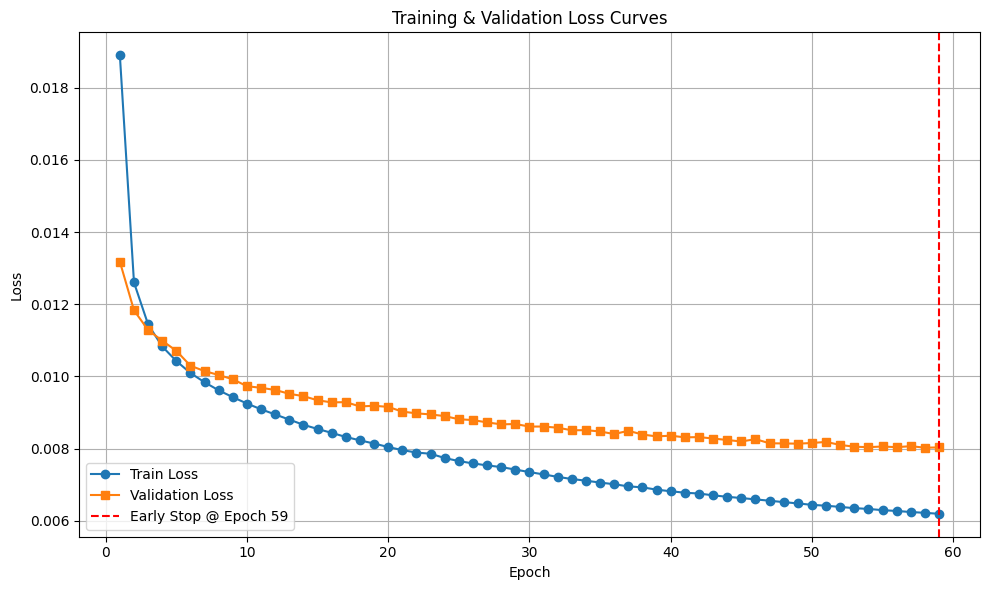

In [15]:
import matplotlib.pyplot as plt
import torch

# --- Paths ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "/kaggle/working/last_checkpoint.pth"

# --- Load checkpoint ---
model = Image2PCgen(num_points=1024).to(DEVICE)
_, train_losses, val_losses, best_val_loss = load_checkpoint(CHECKPOINT_PATH, model, device=DEVICE)

# --- Plotting ---
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")

# If early stopping was triggered, find epoch
if len(val_losses) < 100:  # training ended early
    stop_epoch = len(val_losses)
    plt.axvline(x=stop_epoch, color="red", linestyle="--", label=f"Early Stop @ Epoch {stop_epoch}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation

In [9]:
import torch
import clip
import os
import pickle
from PIL import Image
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CACHE_FILE = "/kaggle/working/shapenet_paths.pkl"
EMBEDDING_FILE = "/kaggle/working/image_embeddings.pkl"

def precompute_image_embeddings():
    if os.path.exists(EMBEDDING_FILE):
        print(f"Embeddings already exist at {EMBEDDING_FILE}. Skipping pre-computation.")
        return

    print("Loading dataset paths...")
    if not os.path.exists(CACHE_FILE):
        raise FileNotFoundError("Run get_dataloaders() once to create shapenet_paths.pkl.")
        
    with open(CACHE_FILE, 'rb') as f:
        all_items = pickle.load(f)

    print("Loading CLIP model...")
    model, preprocess = clip.load("RN50", device=DEVICE)
    model.eval()

    image_embeddings = {}
    
    # Process images in batches for efficiency
    BATCH_SIZE = 64
    all_paths = [item['image_path'] for item in all_items]

    for i in tqdm(range(0, len(all_paths), BATCH_SIZE), desc="Computing Embeddings"):
        batch_paths = all_paths[i:i + BATCH_SIZE]
        
        # Load and preprocess batch of images
        images = [preprocess(Image.open(path).convert('RGB')) for path in batch_paths]
        image_batch = torch.stack(images).to(DEVICE)
        
        with torch.no_grad():
            features = model.encode_image(image_batch)
            features /= features.norm(dim=-1, keepdim=True)
        
        # Store results
        for path, feature in zip(batch_paths, features):
            image_embeddings[path] = feature.cpu() # Store on CPU to save GPU memory

    print(f"Saving {len(image_embeddings)} embeddings to {EMBEDDING_FILE}...")
    with open(EMBEDDING_FILE, 'wb') as f:
        pickle.dump(image_embeddings, f)
    print("Pre-computation complete.")

# Create image embeddings dictionary
precompute_image_embeddings()

Loading dataset paths...
Loading CLIP model...


100%|███████████████████████████████████████| 244M/244M [00:08<00:00, 31.4MiB/s]
Computing Embeddings: 100%|██████████| 4328/4328 [1:06:50<00:00,  1.08it/s]


Saving 276984 embeddings to /kaggle/working/image_embeddings.pkl...
Pre-computation complete.


In [10]:
#----------- RGB2Point model ---------------

import torch.nn as nn
from torch.nn import MultiheadAttention
import torch
import timm
class PointCloudGeneratorWithAttention(nn.Module):
    def __init__(
        self, input_feature_dim, point_cloud_size, num_heads=16, dim_feedforward=2048
    ):
        super(PointCloudGeneratorWithAttention, self).__init__()
        print(f"input_feature_dim:{input_feature_dim}")
        print(f"dim_feedforward:{dim_feedforward}")
        print(f"point_cloud_size:{point_cloud_size*3}")
        self.self_attention = MultiheadAttention(
            embed_dim=input_feature_dim, num_heads=num_heads
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(input_feature_dim, dim_feedforward),
            nn.LeakyReLU(0.2),
            nn.Linear(dim_feedforward, dim_feedforward),
            nn.LeakyReLU(0.2),
            nn.Linear(
                dim_feedforward, point_cloud_size * 3
            ),  # Output layer for point cloud
        )
        self.point_cloud_size = point_cloud_size

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_feature_dim]
        # Transpose for the attention layer
        x = x.transpose(0, 1)  # Shape: [seq_length, batch_size, input_feature_dim]

        # Self-attention
        attn_output, _ = self.self_attention(x, x, x)

        # Transpose back
        attn_output = attn_output.transpose(
            0, 1
        )  # Shape: [batch_size, seq_length, input_feature_dim]

        # Pass through the linear layers
        point_cloud = self.linear_layers(attn_output.flatten(start_dim=1))

        # Reshape to (batch_size, point_cloud_size, 3)
        point_cloud = point_cloud.view(-1, self.point_cloud_size, 3)
        return point_cloud


class PointCloudNet(nn.Module):
    def __init__(self, num_views, point_cloud_size, num_heads, dim_feedforward, device):
        super(PointCloudNet, self).__init__()
        self.device = device
        # Load the pretrained Vision Transformer model from timm
        self.vit = timm.create_model(
            "vit_base_patch16_224", pretrained=True, num_classes=0
        )
        self.vit.to(self.device)
        for param in self.vit.parameters():
            param.requires_grad = False
        # Define the number of features from the ViT model
        num_features = self.vit.num_features

        # Aggregate features from different views
        out_features = 1024 * 4
        self.aggregator = nn.Linear(num_features, out_features)
        # Point cloud generator with attention
        self.point_cloud_generator = PointCloudGeneratorWithAttention(
            input_feature_dim=out_features,
            point_cloud_size=point_cloud_size,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
        )

    def forward(self, x):
        batch_size, num_views, C, H, W = x.shape

        # Process all views in the batch
        x = x.view(batch_size * num_views, C, H, W)

        # Extract features from the views using ViT
        with torch.no_grad():
            features = self.vit(x)

        # Reshape features back to separate views
        features = features.view(batch_size, num_views, -1)

        # Compute the mean of features from all views
        mean_features = torch.mean(features, dim=1)

        # Aggregate features
        aggregated_features = self.aggregator(mean_features)
        aggregated_features = aggregated_features.unsqueeze(1)

        # Generate point cloud
        point_cloud = self.point_cloud_generator(aggregated_features)

        # Reshape to (batch_size, point_cloud_size, 3)
        point_cloud = point_cloud.view(batch_size, -1, 3)

        return point_cloud

# evaluate.py

In [12]:
import os
import json
import torch
from tqdm import tqdm
import kaolin.metrics.pointcloud as pc_metrics
import clip
import pickle
from PIL import Image
"""
from dataset import transform
from model import Image2PCgen
from dataset import get_dataloaders
"""

EMBEDDING_FILE = "/kaggle/working/image_embeddings.pkl"

CATEGORY_NAMES = {
    '02691156': 'Airplane',
    '02958343': 'Car'
}

def evaluate_model(model, test_loader, device, model_name, results_file="results.json"):
   
    model.eval()
    category_metrics = {cat: {"cd": [], "fscore": []} for cat in CATEGORY_NAMES.keys()}

    with torch.no_grad():
        for batch_idx, (images, pcs) in enumerate(tqdm(test_loader, desc=f"Evaluating {model_name}")):
            pcs = pcs.to(device)

            # Handle PointCloudNet (needs [B, num_views, C, H, W])
            if model.__class__.__name__ == "PointCloudNet":
                images = images.unsqueeze(1)

            images = images.to(device)
            preds = model(images).float()  # (B, N, 3)

            # Metrics per sample
            cd_vals = pc_metrics.chamfer_distance(preds, pcs)  # (B,)
            f_vals = pc_metrics.f_score(pcs, preds, radius=0.01)  # (B,)

            # Map results to categories for this batch
            start_idx = batch_idx * test_loader.batch_size
            for i in range(len(images)):
                global_idx = test_loader.dataset.indices[start_idx + i]  
                cat_id = test_loader.dataset.dataset.items[global_idx]['category']
                if cat_id in category_metrics:
                    category_metrics[cat_id]['cd'].append(cd_vals[i].item())
                    category_metrics[cat_id]['fscore'].append(f_vals[i].item())

    # --- Average per category ---
    results = {}
    for cat_id, metrics in category_metrics.items():
        if len(metrics['cd']) == 0:
            continue
        results[CATEGORY_NAMES[cat_id]] = {
            "Chamfer": sum(metrics['cd']) / len(metrics['cd']),
            "F-score": sum(metrics['fscore']) / len(metrics['fscore']),
        }

    # --- Save results ---
    all_results = {}
    if os.path.exists(results_file):
        with open(results_file, 'r') as f:
            all_results = json.load(f)
    all_results[model_name] = results
    with open(results_file, 'w') as f:
        json.dump(all_results, f, indent=4)

    print(f"Saved {model_name} results to {results_file}")
    return results


def retrieve_best_image(prompt: str, device: torch.device):

    if not os.path.exists(EMBEDDING_FILE):
        print(f"Error: Embeddings file not found at {EMBEDDING_FILE}.")
        return None
    
    # Load Pre-computed Image Embeddings
    with open(EMBEDDING_FILE, 'rb') as f:
        image_embeddings_dict = pickle.load(f)
    
    image_paths = list(image_embeddings_dict.keys())
    image_features = torch.stack(list(image_embeddings_dict.values())).to(device)

    # Load CLIP Model (only the text encoder)
    model, _ = clip.load("RN50", device=device)
    model.eval()

    # Encode Text Prompt
    text = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True) # Normalize

    # Calculate Cosine Similarity
    # (Text Feature: 1 x D) @ (Image Features: N x D).T -> 1 x N
    similarities = (text_features @ image_features.T).squeeze(0)
    
    # Find the Best Match
    best_idx = similarities.argmax().item()
    best_image_path = image_paths[best_idx]
    best_similarity = similarities[best_idx].item()
    
    return best_image_path


def text_inference(model, device, prompt: str):

    model.eval()
    best_image_path = retrieve_best_image(prompt, device)
    image = Image.open(best_image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device) 
    with torch.no_grad():
        preds = model(image_tensor).float()  # (1, N, 3)
    
    return preds

In [14]:
#----------- Evaluation: Our Model -------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, _, test_loader = get_dataloaders()
model = Image2PCgen(num_points=1024).to(device)
checkpoint = torch.load("/kaggle/working/best_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# Run evaluation
results = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device,
    model_name="Image2PCgen-(ours)",
    results_file="/kaggle/working/results.json"
)

Loading dataset file paths from cache...
Loaded 276984 samples from cache.
Total number of samples: 276984
Training samples: 193888
Validation samples: 55396
Test samples: 27700


Evaluating Image2PCgen-(ours): 100%|██████████| 866/866 [10:26<00:00,  1.38it/s]

Saved Image2PCgen-(ours) results to /kaggle/working/results.json


In [15]:
#----------- Evaluation: RGB2Point -------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, _, test_loader = get_dataloaders()
model = PointCloudNet(num_views=1, point_cloud_size=1024, num_heads=4, dim_feedforward=2048, device=device)
model.load_state_dict(torch.load("/kaggle/input/rgb2point/pc1024_three.pth")["model"])
model.to(device)

# Run evaluation
results = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device,
    model_name="RGB2Point",
    results_file="/kaggle/working/results.json"
)

Loading dataset file paths from cache...
Loaded 276984 samples from cache.
Total number of samples: 276984
Training samples: 193888
Validation samples: 55396
Test samples: 27700
input_feature_dim:4096
dim_feedforward:2048
point_cloud_size:3072


Evaluating RGB2Point: 100%|██████████| 866/866 [05:52<00:00,  2.45it/s]

Saved RGB2Point results to /kaggle/working/results.json


In [17]:
#--------- Text to Point Cloud inference -----------
import plotly.graph_objects as go
import numpy as np

# Example of how to add visualization in the main block
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Image2PCgen(num_points=1024).to(device)
    checkpoint = torch.load("/kaggle/working/best_checkpoint.pth", map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])

    # ----------------Insert text prompt here-------------
    text_prompt = "An old model plane with propeller"
    generated_pc_tensor = text_inference(
        model=model,
        device=device,
        prompt=text_prompt,
    )

    if generated_pc_tensor is not None:
        print("\nPlotting the generated point cloud...")
        
        # Squeeze the tensor to (N, 3) and convert to a NumPy array
        generated_pc_np = generated_pc_tensor.squeeze(0).cpu().numpy()

        # Create a Plotly 3D scatter plot
        fig = go.Figure(data=[go.Scatter3d(
            x=generated_pc_np[:, 0],  
            y=generated_pc_np[:, 1], 
            z=generated_pc_np[:, 2],  
            mode='markers',
            marker=dict(
                size=1.5,
                color='blue',
                opacity=0.8
            )
        )])

        fig.update_layout(
            title=f"Generated Point Cloud for Prompt: '{text_prompt}'",
            scene=dict(
                xaxis_title='X Axis',
                yaxis_title='Y Axis',
                zaxis_title='Z Axis',
                aspectmode='data'
            )
        )
  
        fig.show()


Plotting the generated point cloud...
